In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import torch
from matplotlib import rc

%matplotlib inline
###
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
###
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [3]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.metrics import confusion_matrix, classification_report


In [6]:
#path_1 = 'datasets/IMDBDatasetSPANISH.csv'
#path_2 = 'datasets/filmaffinity'
#path_3 = 'datasets/muchocine'
#df_1 = pd.read_csv(path_1)
#df_2 = pd.read_csv(path_2)
#df_3 = pd.read_csv(path_3)
df_1 = pd.read_csv("/content/drive/MyDrive/deepLearning/datasets/IMDBDatasetSPANISH.csv")
df_2 = pd.read_csv("/content/drive/MyDrive/deepLearning/datasets/filmaffinity")
df_3 = pd.read_csv("/content/drive/MyDrive/deepLearning/datasets/muchocine")
print("---one---")
print(df_1.head())
print("---two---")
print(df_2.head())
print("---three---")
print(df_3.head())

---one---
   Unnamed: 0                                          review_en  \
0           0  One of the other reviewers has mentioned that ...   
1           1  A wonderful little production. The filming tec...   
2           2  I thought this was a wonderful way to spend ti...   
3           3  Basically there's a family where a little boy ...   
4           4  Petter Mattei's "Love in the Time of Money" is...   

                                           review_es sentiment sentimiento  
0  Uno de los otros críticos ha mencionado que de...  positive    positivo  
1  Una pequeña pequeña producción.La técnica de f...  positive    positivo  
2  Pensé que esta era una manera maravillosa de p...  positive    positivo  
3  Básicamente, hay una familia donde un niño peq...  negative    negativo  
4  El "amor en el tiempo" de Petter Mattei es una...  positive    positivo  
---two---
                                                text  sentiment
0  La mayor virtud de esta película es su exi

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(device)
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(device)
else:
    device = torch.device("cpu")
    print(device)

cuda


In [8]:
def to_sentiment(sentiment):
    sentiment = str(sentiment)
    if sentiment == 'positive':
        return 1
    elif sentiment == 'negative':
        return 0
    else:
        return 2

In [9]:
#Check spanish
def selectLanguage(language, data):
    if language == "spanish":
        data['is_positive'] = data.sentiment.apply(to_sentiment)
        del data['review_en']
        del data['sentimiento']
        del data['sentiment']
        data.columns = ['id_review', 'text', 'sentiment']
        del data['id_review']
    elif language == "english":
        del data['review_es']
        del data['sentimiento']
        del data[data.columns[0]]
        data.rename(columns={'review_en': 'text'}, inplace=True)
        data['sentiment'] = data.sentiment.apply(to_sentiment)
    return data

In [10]:
idioma = "spanish"
df_1 = selectLanguage(idioma, df_1)

In [11]:
def selectTexts(dataSet, words):
    list_text= []
    list_label= []
    for (text, target) in zip(dataSet.text, dataSet.sentiment):
        if (len(text.split())) <= words:
            list_text.append(text)
            list_label.append(target)
    DFTrain_clean = list(zip(list_text, list_label))
    DFTrain_clean = pd.DataFrame(DFTrain_clean, columns=['text','sentiment'])
    return DFTrain_clean

In [12]:
df_1 = selectTexts(df_1, 160)

### Fusión


In [13]:
data = df_1
data= pd.concat([data, df_2])
data= pd.concat([data, df_3])

In [14]:
data

,text,sentiment
0,"Básicamente, hay una familia donde un niño peq...",0
1,Probablemente mi película favorita de todos lo...,1
2,Seguro que me gustaría ver una resurrección de...,1
3,Alentados por los comentarios positivos sobre ...,0
4,"Si te gusta la risa original desgarradora, te ...",1
...,...,...
3867,"Película dirigida a un público adolescente, co...",0
3868,Bergman en estado puro. Duro a la par que sens...,0
3869,Por fin vemos un Almodóvar que retrata escenas...,0
3870,Dos horas entretenidillas de thriller con cier...,0


In [15]:
data.rename(columns={'text': 'content'}, inplace=True)

In [16]:
ones = data['sentiment'].value_counts()[1]
ceros = data['sentiment'].value_counts()[0]
print("Positivos:", ones)
print("Negativos:", ceros )
print("----")
print("Totales:",ones+ceros )

Positivos: 15836
Negativos: 19331
----
Totales: 35167


In [17]:
data.rename(columns={'text': 'content'}, inplace=True)

In [18]:
data['sentiment']

0       0
1       1
2       1
3       0
4       1
       ..
3867    0
3868    0
3869    0
3870    0
3871    0
Name: sentiment, Length: 35167, dtype: int64

In [19]:
class_names = ['negative', 'positive']

In [20]:
PRE_TRAINED_MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-cased'

In [21]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

In [22]:
  sample_txt = "No me gusto la pelicula"

In [23]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [24]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([   4, 1125, 1129, 5980, 1030, 4264, 8186,    5,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1])

In [25]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [26]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'No',
 'me',
 'gusto',
 'la',
 'peli',
 '##cula',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

## Choosing Sequence Length



In [27]:
token_lens = []
for txt in data.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

<ipython-input-28-47bafb326c13>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

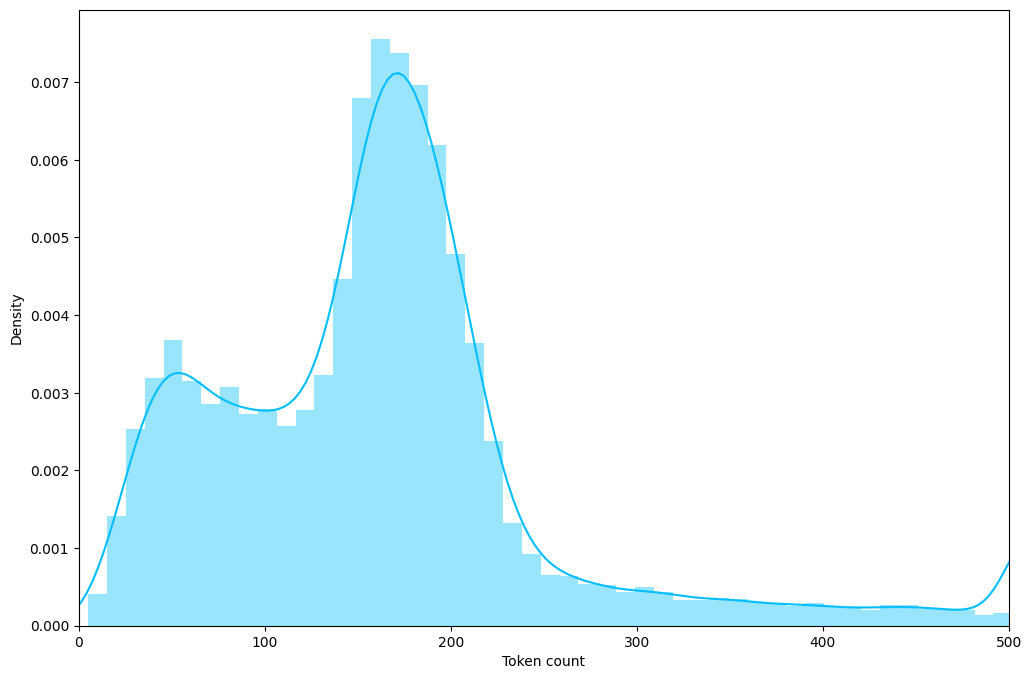

In [28]:
sns.distplot(token_lens)
#plt.xlim([0, 256]);
plt.xlim([0, 500]);
plt.xlabel('Token count')

In [29]:
MAX_LEN = 160

In [30]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [31]:
df_train, df_test = train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [32]:
df_train.shape, df_val.shape, df_test.shape

((31650, 2), (1758, 2), (1759, 2))

In [33]:
df_train

,content,sentiment
19304,"Hecho en un estilo documental simulado, los su...",0
5924,Además de perpetuar estereotipos y de fomentar...,0
7949,A favor: recreación de los escenarios muy cons...,1
653,"Una obra convulsa, abierta a muchas lecturas. ...",1
14170,Una versión actualizada de un tema que se ha h...,0
...,...,...
16850,"Vamos a enfrentarlo, sabe qué esperar cuando s...",1
6265,Como yo y mi otra mitad son grandes fanáticos ...,0
11284,"Tienes que admirar a Brad Sykes, incluso si no...",0
860,"Si tiene actores queridos, Peter Falk, RIP TOR...",0


In [34]:
df_test

,content,sentiment
93,Una mezcla entre Crash y Lost In Traslation. 4...,0
16921,"No había escuchado mucho sobre esta película, ...",1
5456,Vuelve Almodóvar y pisando fuerte. El manchego...,1
4308,¡Es agradable ver un espectáculo que tiene un ...,1
11626,"Solo vi esta película una vez, y eso fue sufic...",0
...,...,...
3230,He leído los 28 comentarios más recientes de v...,0
245,"Le falta pasión cinematográfica, estar a la al...",0
1423,Hecho y lanzado en el momento en que Internet ...,0
1852,Una maravilla de terror que hará las delicias ...,0


In [35]:
df_val

,content,sentiment
34,Estupenda cinta de animación con mensaje ecoló...,0
19397,La pesadilla de un insomní es la historia de u...,1
2865,Mientras veía la película he llorado y he reíd...,1
11225,No solo los efectos y la actuación en esta pel...,0
15877,Esta película mostró más odio racial de los ju...,0
...,...,...
8474,"Bueno, pues nos hallamos ante una de esas pelí...",1
6700,"waaauu fantástica desde la primer toma, muy or...",1
14807,"Esta película tenía muy pocos puntos buenos, l...",0
14442,"Por alguna razón, la Guía de TV le dio a estas...",0


In [36]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [37]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [38]:
dataNew = next(iter(train_data_loader))
dataNew.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [39]:
print(dataNew['input_ids'].shape)
print(dataNew['attention_mask'].shape)
print(dataNew['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


### Modelo

In [40]:
bert_model = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'], return_dict=False
)

In [42]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [43]:
bert_model.config.hidden_size

768

In [44]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask, return_dict):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask, return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [45]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [46]:
input_ids = dataNew['input_ids'].to(device)
attention_mask = dataNew['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [47]:
type(input_ids)

torch.Tensor

In [48]:
F.softmax(model(input_ids, attention_mask,return_dict=False), dim=1)

tensor([[0.5683, 0.4317],
        [0.5222, 0.4778],
        [0.6189, 0.3811],
        [0.6264, 0.3736],
        [0.5906, 0.4094],
        [0.5370, 0.4630],
        [0.6368, 0.3632],
        [0.5802, 0.4198],
        [0.6592, 0.3408],
        [0.5298, 0.4702],
        [0.5771, 0.4229],
        [0.6078, 0.3922],
        [0.6643, 0.3357],
        [0.6902, 0.3098],
        [0.7007, 0.2993],
        [0.5852, 0.4148]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [49]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [50]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask, return_dict= False
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [51]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict= False
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
from collections import defaultdict


In [53]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_beto_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.war

Train loss 0.6883141025863193 accuracy 0.5330173775671406


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6763655808838931 accuracy 0.5466439135381115

Epoch 2/5
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.6758461036785737 accuracy 0.5397472353870458


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6888605789704756 accuracy 0.5466439135381115

Epoch 3/5
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.6897604303145541 accuracy 0.5479936808846761


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6887323000214317 accuracy 0.5466439135381115

Epoch 4/5
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.6775135534348182 accuracy 0.5815481832543444


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.678782646222548 accuracy 0.5836177474402731

Epoch 5/5
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.6668668300922378 accuracy 0.6039810426540284


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.6666983179070732 accuracy 0.6097838452787258

CPU times: user 47min 55s, sys: 24min 57s, total: 1h 12min 53s
Wall time: 1h 17min 49s


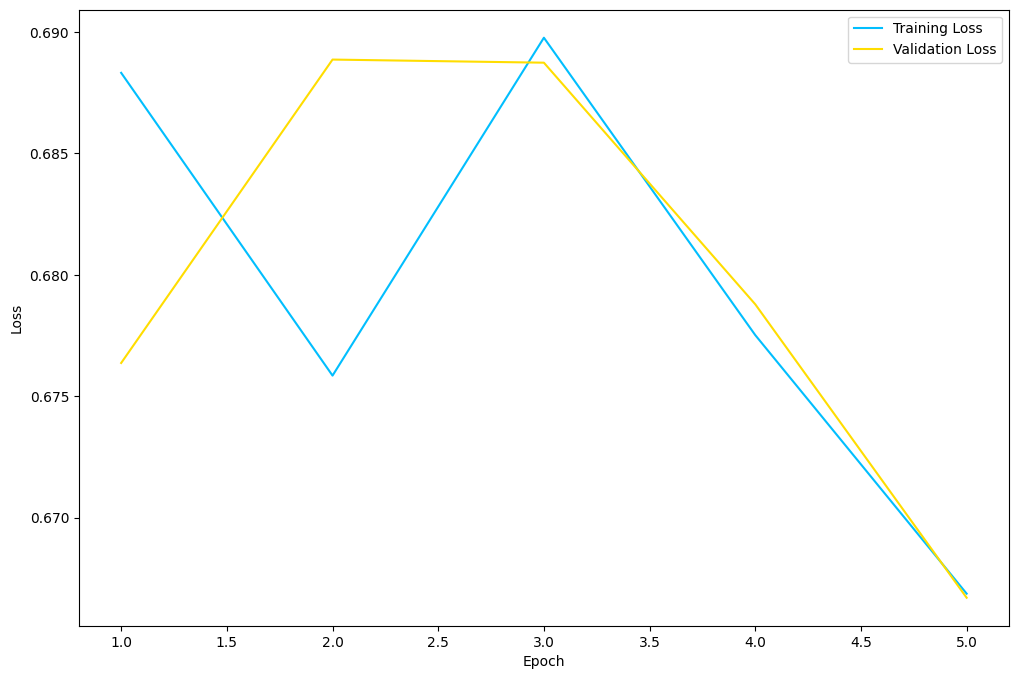

In [54]:
import matplotlib.pyplot as plt
import numpy as np
# Graficar el error en entrenamiento y validación por época
e = 4
train_losses = history['train_loss']
val_losses = history['val_loss']
epochs_range = np.arange(1, e + 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.figure(figsize=(0.2,0.1))
plt.show()


In [55]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

0.6293348493462194

In [56]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict= False
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [57]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [58]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.65      0.68      0.66       944
    positive       0.61      0.57      0.59       815

    accuracy                           0.63      1759
   macro avg       0.63      0.63      0.63      1759
weighted avg       0.63      0.63      0.63      1759

